In [1]:
import numpy as np
import tensorflow as tf
import pickle
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC


2024-01-02 23:06:35.105231: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-02 23:06:35.179822: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-02 23:06:35.179878: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-02 23:06:35.179944: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-02 23:06:35.194991: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-02 23:06:35.195940: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

# Load Data

In [2]:
import os
import numpy as np


def load_data(folder):
    data = []
    labels = []
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file)
                if file.endswith('.npy'):
                    # Load numpy array
                    array = np.load(file_path).flatten()
                    data.append(array)
                    # Label phishing as 1, benign as 0
                    label = 1 if (folder.find('phishing') != -1) else 0
                    labels.append(label)
    return np.array(data), np.array(labels)

# Đường dẫn đến thư mục chứa dữ liệu
phishing_path = 'VisualPhish/phishing_features'
benign_path = 'VisualPhish/trusted_list_features'

# Load dữ liệu
phishing_data, phishing_labels = load_data(phishing_path)
benign_data, benign_labels = load_data(benign_path)



In [3]:
print(phishing_data.shape)
print(phishing_labels.shape)
print(benign_data.shape)
print(benign_labels.shape)

(1195, 512)
(1195,)
(9363, 512)
(9363,)


In [4]:
from sklearn.model_selection import train_test_split

def split_and_remove(data, labels):
    # Tách 20% dữ liệu cho test set và lưu chỉ mục
    train_idx, test_idx = train_test_split(
        np.arange(len(labels)), test_size=0.2, random_state=42, stratify=labels)

    # Phân chia dữ liệu dựa trên chỉ mục
    test_set = data[test_idx]
    test_labels = labels[test_idx]
    train_set = np.delete(data, test_idx, axis=0)
    train_labels = np.delete(labels, test_idx, axis=0)
    return train_set, train_labels, test_set, test_labels

# Áp dụng cho dữ liệu phishing và benign
phishing_train, phishing_labels_train, phishing_test, phishing_labels_test = split_and_remove(phishing_data, phishing_labels)
benign_train, benign_labels_train, benign_test, benign_labels_test = split_and_remove(benign_data, benign_labels)

# Gộp dữ liệu huấn luyện và kiểm thử
train_data = np.concatenate((phishing_train, benign_train))
train_labels = np.concatenate((phishing_labels_train, benign_labels_train))
test_data = np.concatenate((phishing_test, benign_test))
test_labels = np.concatenate((phishing_labels_test, benign_labels_test))


In [5]:
print(phishing_train.shape)
print(phishing_labels_train.shape)
print(phishing_test.shape)
print(phishing_labels_test.shape)
print(benign_train.shape)
print(benign_labels_train.shape)
print(benign_test.shape)
print(benign_labels_test.shape)
print('======')
print(test_data.shape)
print(test_labels.shape)

(956, 512)
(956,)
(239, 512)
(239,)
(7490, 512)
(7490,)
(1873, 512)
(1873,)
(2112, 512)
(2112,)


# DCGAN

In [6]:
def build_generator(noise_dim):
    model = tf.keras.Sequential([
        Dense(256, input_shape=(noise_dim,)),
        LeakyReLU(alpha=0.2),
        Dense(512),  # Tăng số lượng neuron
        LeakyReLU(alpha=0.2),
        Dense(1024),  # Tăng thêm số lượng neuron
        LeakyReLU(alpha=0.2),
        Dense(512)  # Output layer với 512 units
    ])
    return model

def build_discriminator():
    model = tf.keras.Sequential([
        Dense(1024, input_shape=(512,)),
        LeakyReLU(alpha=0.2),
        Dense(512),  # Giảm số lượng neuron
        LeakyReLU(alpha=0.2),
        Dense(256),  # Giảm thêm số lượng neuron
        LeakyReLU(alpha=0.2),
        Dense(1, activation='sigmoid')  # Output layer
    ])
    return model

In [7]:
def build_gan(generator, discriminator):
    model = Sequential()

    model.add(generator)
    model.add(discriminator)

    return model

z_dim = 100
batch_size = 32
learning_rate = 0.0002

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])

generator = build_generator(z_dim)

discriminator.trainable = False
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate))


In [8]:
generator.summary()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 512)              

In [8]:
def train_gan(gan, generator, discriminator, dataset, z_dim, epochs=100):
    for epoch in range(epochs):
        for real_images in dataset:
            # Điều chỉnh kích thước của z dựa trên kích thước thực tế của real_images
            current_batch_size = real_images.shape[0]
            z = np.random.normal(0, 1, (current_batch_size, z_dim))
            fake_images = generator.predict(z, verbose=0)

            combined_images = np.concatenate([real_images, fake_images])
            labels = np.concatenate([np.ones((current_batch_size, 1)), np.zeros((current_batch_size, 1))])
            labels += 0.05 * np.random.random(labels.shape)

            d_loss = discriminator.train_on_batch(combined_images, labels)

            z = np.random.normal(0, 1, (current_batch_size, z_dim))
            fake_labels = np.ones((current_batch_size, 1))

            g_loss = gan.train_on_batch(z, fake_labels)

        print(f"Epoch: {epoch + 1}, D Loss: {d_loss[0]}, G Loss: {g_loss}")


# Chia dataset thành các batch
dataset = [phishing_data[i:i + batch_size] for i in range(0, len(phishing_data), batch_size)]
if len(dataset[-1]) != batch_size:
    dataset.pop()  # Xóa batch cuối nếu kích thước không phù hợp


"""
# Tái tạo kiến trúc mô hình
generator = build_generator(z_dim)
discriminator = build_discriminator()

# Tải trọng số
generator.load_weights('generator_weights_gan.h5')
discriminator.load_weights('discriminator_weights_gan.h5')
"""


# Khởi tạo và huấn luyện mô hình GAN
train_gan(gan, generator, discriminator, dataset, z_dim, 2000)
generator.save_weights('generator_weights_gan.h5')
discriminator.save_weights('discriminator_weights_gan.h5')



Epoch: 1, D Loss: 6.669939994812012, G Loss: 0.011001106351613998
Epoch: 2, D Loss: 6.902899742126465, G Loss: 9.865272521972656
Epoch: 3, D Loss: -6.721072196960449, G Loss: 33.344146728515625
Epoch: 4, D Loss: -27.434661865234375, G Loss: 103.53710174560547
Epoch: 5, D Loss: -19.604625701904297, G Loss: 108.72645568847656
Epoch: 6, D Loss: 6.727492809295654, G Loss: 83.29505920410156
Epoch: 7, D Loss: 17.852798461914062, G Loss: 1.1009833812713623
Epoch: 8, D Loss: 1.807241439819336, G Loss: 58.1837272644043
Epoch: 9, D Loss: 113.80995178222656, G Loss: 0.0
Epoch: 10, D Loss: -0.8085185289382935, G Loss: 1.224791407585144
Epoch: 11, D Loss: -1.6941297054290771, G Loss: 5.567266464233398
Epoch: 12, D Loss: 4.1105475425720215, G Loss: 0.03337419033050537
Epoch: 13, D Loss: 0.314744770526886, G Loss: 0.9535006284713745
Epoch: 14, D Loss: -0.1762608140707016, G Loss: 3.7234604358673096
Epoch: 15, D Loss: 0.0027856826782226562, G Loss: 2.3643980026245117
Epoch: 16, D Loss: -0.913378238677

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def showFeature(features):
  image = features.reshape(16, 32)
  #print(image.shape)
  #print(image)
  
  plt.subplot(1, 1, 1)  # Tạo subplot
  plt.imshow(image, cmap='viridis')  # Sử dụng viridis làm bảng màu
  plt.title(f'Feature map')
  plt.axis('off')  # Ẩn trục tọa độ

  plt.show()

================ 0 =================
Fake:


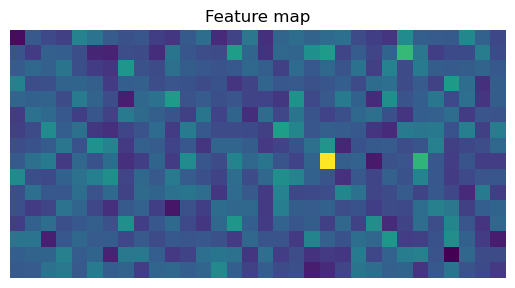

Real:


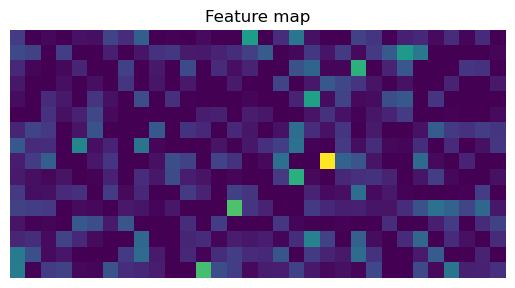

[-1.86421928e+01  4.28393269e+00 -1.15601981e+00 -4.18474770e+00
  1.93918800e+01  1.37141981e+01  5.06095171e+00  1.34288347e+00
  2.99841309e+00 -4.58504629e+00 -6.77374411e+00  4.45740414e+00
  1.13855734e+01 -1.05916023e+01 -2.54278159e+00  1.50603209e+01
 -9.29679298e+00  8.43993568e+00  1.16135054e+01  7.96134806e+00
  1.07267218e+01  1.21418390e+01 -1.32016182e-01 -4.36124611e+00
 -7.50393724e+00  2.29630527e+01  6.25579357e+00  5.02898502e+00
  4.73771954e+00  2.11078377e+01  7.03381681e+00 -1.40054059e+00
  2.24091053e+00 -5.01370525e+00  6.69944620e+00  5.99116659e+00
  4.35621619e-01 -1.21964045e+01 -1.25878811e+01  3.89297009e-01
 -3.97225797e-01 -9.35318279e+00  1.41841431e+01  3.07826447e+00
  1.45000607e-01 -4.63916183e-01  2.99140949e+01  8.45682526e+00
 -8.16820145e+00  9.47336769e+00  8.62598801e+00  2.47212582e+01
  2.95245667e+01 -2.26492500e+00  5.46562862e+00 -2.31887507e+00
  8.20686054e+00  4.04632111e+01  1.49277830e+01 -4.53181458e+00
 -1.00625908e+00 -9.98798

In [10]:
z = np.random.normal(0, 1, (10, z_dim))
fake_images = generator.predict(z, verbose=0)
for i in range(1):
  print("================", i, "=================")
  print("Fake:")
  showFeature(fake_images[i])
  print("Real:")
  showFeature(dataset[0][i])
  print(fake_images[i])
  print(dataset[0][i])

In [ ]:
"""
@tf.function
def train_step(images, z_dim, discriminator, generator, discriminator_optimizer, generator_optimizer):
    # Tạo nhiễu ngẫu nhiên
    noise = tf.random.normal([batch_size, z_dim])

    # GradientTape cho discriminator
    with tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # GradientTape cho generator
    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    """


# DNN

In [6]:

def create_model():
    DNN_model = Sequential([
        Dense(1024, activation='relu', input_shape=(512,)),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return DNN_model

In [7]:
# Chia dữ liệu thành 10 phần

federated_data = []

# Giả sử X, y là dữ liệu của bạn
num_clients = 1

num_samples_phishing_per_client = len(phishing_train) // num_clients
num_samples_benign_per_client = len(benign_train) // num_clients

for i in range(num_clients):
    start_idx = i * num_samples_phishing_per_client
    end_idx = (i + 1) * num_samples_phishing_per_client if i != num_clients - 1 else len(phishing_train)
    
    start_idx_benign = i * num_samples_benign_per_client
    end_idx_benign = (i + 1) * num_samples_benign_per_client if i != num_clients - 1 else len(benign_train)

    X_client_phishing = phishing_train[start_idx:end_idx]
    y_client_phishing = phishing_labels_train[start_idx:end_idx]

    X_client_benign = benign_train[start_idx_benign:end_idx_benign]
    y_client_benign = benign_labels_train[start_idx_benign:end_idx_benign]

    print("Client ", i, ": ")
    while (len(X_client_phishing) < len(X_client_benign)):
        print(len(X_client_phishing), "/", len(X_client_benign))

        print(len(y_client_phishing), "/", len(y_client_benign))
        z = np.random.normal(0, 1, (1, z_dim))
        gen_img = generator.predict(z, verbose=0)

        X_client_phishing = np.vstack((X_client_phishing, gen_img[0]))
        y_client_phishing = np.append(y_client_phishing, 1)

    X_client = np.concatenate((X_client_phishing, X_client_benign), axis=0)
    y_client = np.concatenate((y_client_phishing, y_client_benign), axis=0)
    print(X_client.shape)
    print(y_client.shape)
    federated_data.append((X_client, y_client))



Client  0 : 
956 / 7490
956 / 7490


NameError: name 'z_dim' is not defined

In [26]:
with open('federated_data.pkl', 'wb') as f:
    pickle.dump(federated_data, f)
np.savez('test_data.npz', testX=test_data, testy=test_labels)


In [3]:

loaded_arrays = np.load('test_data.npz')

# Accessing the arrays
test_data = loaded_arrays['testX']
test_labels = loaded_arrays['testy']

with open('federated_data.pkl', 'rb') as f:
    federated_data = pickle.load(f)


In [13]:
def preprocessing(X_data, y_data):
    # Chuyển đổi sang TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((X_data, y_data))
    dataset = dataset.batch(64) # BatchSize
    return dataset

In [14]:
federated_data_train = [preprocessing(X_client, y_client) for X_client, y_client in federated_data]

In [15]:
def has_weights_changed(old_weights, new_weights, tolerance=1e-5):
    """
    Kiểm tra xem trọng số của mô hình có thay đổi giữa các vòng đào tạo hay không.
    :param old_weights: Trọng số của mô hình từ vòng trước.
    :param new_weights: Trọng số mới của mô hình.
    :param tolerance: Ngưỡng dung sai cho sự thay đổi.
    :return: True nếu có sự thay đổi, ngược lại False.
    """
    for old_layer, new_layer in zip(old_weights, new_weights):
        if np.any(np.abs(new_layer - old_layer) > tolerance):
            return True
    return False

In [16]:
print(len(test_data))

2112


In [17]:
# Tạo tập dữ liệu từ test_data và test_labels
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

# Chia thành các batch (ví dụ: batch_size=32)
test_dataset = test_dataset.batch(64)

In [57]:
model = create_model()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [58]:
from tensorflow.keras.callbacks import EarlyStopping

# Tạo một callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',   # Giám sát mất mát của tập kiểm định
    min_delta=0.00000001,      # Thay đổi tối thiểu để coi là cải thiện
    patience=10,          # Số lượng epochs không cải thiện trước khi dừng
    verbose=1,            # Hiển thị thông báo khi dừng
    mode='min',           # Dừng quá trình huấn luyện khi giá trị 'val_loss' không giảm
    restore_best_weights=True # Khôi phục trọng số tốt nhất khi kết thúc
)

# Giả sử 'model' là mô hình của bạn và bạn đã chuẩn bị dữ liệu
# model = ...

# Huấn luyện mô hình với dữ liệu và callback EarlyStopping
history = model.fit(
    federated_data_train[0],
    validation_data=test_dataset,
    epochs=1000,          # Số lượng epochs tối đa
    callbacks=[early_stopping]
)
# In số lượng epochs đã thực hiện
print("Số lượng epochs đã thực hiện:", len(history.history['loss']))


Epoch 1/1000
235/235 [==============================] - 6s 18ms/step - loss: 2.7708 - accuracy: 0.9874 - val_loss: 112.2649 - val_accuracy: 0.8868
Epoch 2/1000
235/235 [==============================] - 4s 17ms/step - loss: 7.1829 - accuracy: 0.9745 - val_loss: 7.3056 - val_accuracy: 0.8868
Epoch 3/1000
235/235 [==============================] - 4s 17ms/step - loss: 7.2921 - accuracy: 0.9489 - val_loss: 19.4493 - val_accuracy: 0.8868
Epoch 4/1000
235/235 [==============================] - 4s 17ms/step - loss: 2.1670 - accuracy: 0.9422 - val_loss: 14.5480 - val_accuracy: 0.8868
Epoch 5/1000
235/235 [==============================] - 4s 17ms/step - loss: 3.0029 - accuracy: 0.9192 - val_loss: 6.1184 - val_accuracy: 0.8868
Epoch 6/1000
235/235 [==============================] - 4s 17ms/step - loss: 0.7787 - accuracy: 0.9315 - val_loss: 2.1150 - val_accuracy: 0.8868
Epoch 7/1000
235/235 [==============================] - 4s 17ms/step - loss: 0.6721 - accuracy: 0.9215 - val_loss: 3.1534 - va

In [25]:
model.evaluate(test_dataset)
# test_data => wrong

28/33 [========================>.....] - ETA: 0s - loss: 5.1750 - accuracy: 0.8666 

33/33 [==============================] - 0s 8ms/step - loss: 4.3909 - accuracy: 0.8868


[4.390923500061035, 0.8868371248245239]

In [37]:
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score

def evaluate_model(model, test_dataset, loss_fn):
    # Đánh giá mô hình trên tập dữ liệu kiểm tra
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)

    # Dự đoán nhãn và tính toán các chỉ số
    y_true = np.concatenate([y_batch.numpy().flatten() for _, y_batch in test_dataset])
    y_pred = np.concatenate([model.predict(x_batch, verbose=0).flatten() for x_batch, _ in test_dataset])

    y_pred_rounded = np.array([1 if y > 0.5 else 0 for y in y_pred])

    print(len(y_true))
    print(len(y_pred))
    cnt0 = 0
    cnt1 = 0
    for y in y_pred_rounded:
        if y == 0:
            cnt0 += 1
        else:
            cnt1 += 1
    print(cnt0)
    print(cnt1)

    # Tính toán các chỉ số đánh giá
    f1 = f1_score(y_true, y_pred_rounded)
    recall = recall_score(y_true, y_pred_rounded)
    precision = precision_score(y_true, y_pred_rounded)
    auc = roc_auc_score(y_true, y_pred_rounded)

    return test_loss, test_accuracy, f1, recall, precision, auc


In [59]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
test_loss, test_accuracy, f1, recall, precision, auc = evaluate_model(model, test_dataset, loss_fn)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test F1: {f1}")
print(f"Test Recall: {recall}")
print(f"Test Precision: {precision}")
print(f"Test Auc: {auc}")

2112
2112
2110
2
Test Loss: 0.3512907326221466
Test Accuracy: 0.8877840638160706
Test F1: 0.016597510373443983
Test Recall: 0.008368200836820083
Test Precision: 1.0
Test Auc: 0.50418410041841


In [40]:

def train_model_on_client(model, client_dataset, epochs=1):
    for epoch in range(epochs):
        print("e:",epoch)
        for step, (x_batch_train, y_batch_train) in enumerate(client_dataset):
            loss, accuracy = model.train_on_batch(x_batch_train, y_batch_train)
        print(f'Loss: {loss}, Accuracy: {accuracy}')
    
    return model.get_weights(), loss, accuracy
    
def aggregate_weights(client_weights):
    new_weights = [np.mean([client_weights[i][layer] for i in range(len(client_weights))], axis=0) for layer in range(len(client_weights[0]))]
    return new_weights

# Training loop
global_model = create_model()

global_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

previous_weights = global_model.get_weights()

for round_num in range(1):
    print("/////////////////////////////ROUND ", round_num + 1, "///////////////////////////")
    client_weights = []
    losses = []
    accuracies = []

    for client_data in federated_data_train:
        weights, loss, accuracy = train_model_on_client(global_model, client_data, epochs=1)
        client_weights.append(weights)
        losses.append(loss)
        accuracies.append(accuracy)
        if has_weights_changed(weights, previous_weights):
            print("Client i weight thay doi")
        else:
            print("Client i weight khong doi")
    
    # Aggregate the weights and update the global model
    averaged_weights = aggregate_weights(client_weights)
    global_model.set_weights(averaged_weights)
    

    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    test_loss, test_accuracy, f1, recall, precision, auc = evaluate_model(global_model, test_dataset, loss_fn)

    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test F1: {f1}")
    print(f"Test Recall: {recall}")
    print(f"Test Precision: {precision}")
    print(f"Test Auc: {auc}")

    if has_weights_changed(previous_weights, averaged_weights):
        print(f"Trọng số thay đổi sau vòng {round_num + 1}")
    else:
        print(f"Không có sự thay đổi trong trọng số sau vòng {round_num + 1}")

    # Cập nhật trọng số cho vòng tiếp theo
    
    previous_weights = averaged_weights
    
    # Evaluate the model on the test data
    print("res")
    
    global_model.evaluate(test_dataset)
    res = global_model.predict(test_dataset).flatten()
    print(res)

    


/////////////////////////////ROUND  1 ///////////////////////////
e: 0
Loss: 0.0, Accuracy: 1.0
Client i weight thay doi
2112
2112
Test Loss: 20.750492095947266
Test Accuracy: 0.8868371248245239
Test F1: 0.0
Test Recall: 0.0
Test Precision: 0.0
Test Auc: 0.5
Trọng số thay đổi sau vòng 1
res
24/33 [====================>.........] - ETA: 0s - loss: 28.5319 - accuracy: 0.8444   

/home/haohao/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


33/33 [==============================] - 0s 6ms/step
[0. 0. 0. ... 0. 0. 0.]
